In [1]:
import os
from sklearn.metrics import r2_score
import pwlf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import sklearn
%matplotlib inline
import missingno as msno
np.random.seed(19)
from matplotlib.pyplot import figure
data_directory = '/work2/05067/nagyz/austin_energy/data/'
filepaths = [os.path.join(data_directory,f) for f in os.listdir(data_directory) if f.endswith('.csv')]
from datetime import datetime 
from Graphs import load_data,load_graph_kwh,yearly_graph_kwh,load_graph_count,monthly_graph_kwh,daily_graph_kwh
from Graphs import load_graph_kwh_and_count,yearly_graph_kwh_and_count,monthly_graph_kwh_and_count,daily_graph_kwh_and_count
from agg_and_heatmap_functions import length,prav3,prav2,prav1,dinostorm,plot_aggraph,heatmap,finalheatmap
from sklearn.model_selection import train_test_split,RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, SGDRegressor,LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor,GradientBoostingRegressor,RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error,accuracy_score
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression,LassoCV,Ridge,Lasso
from sklearn.model_selection import GridSearchCV,KFold,TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score


In [2]:
"""for i, row in tqdm(id_list.iterrows()):
    point = row['Service Point']
    example_ts = pd.read_csv('/work2/05067/nagyz/austin_energy/data/_4_exports_UT/UT_sID_'+str(point)+'_dates_2017.01.01_through_2021.10.01.csv')
    example_ts.index = pd.to_datetime(example_ts.index)
    example_ts = example_ts.resample('H').mean()
    example_ts = example_ts.drop([f'{point} count Value'], axis = 1)
    example_ts = example_ts['2021-02':'2021-02']
    
    
    # condition with energy that outage happen
    energy = example_ts.iloc[:, 0]
    Q3 = np.quantile(energy, 1)
    Q1 = np.quantile(energy, 0.1)
    energy_con = ~energy['2021-02-12':'2021-02-20'].between(Q1, Q3)

    meter_used = example_ts.iloc[:, 1]
    Q3 = np.quantile(meter_used, 1)
    Q1 = np.quantile(meter_used, 0.1)
    meter_used_con = ~meter_used['2021-02-12':'2021-02-20'].between(Q1, Q3)
    
    happen = len(example_ts['2021-02-12':'2021-02-20'][(energy_con) | (meter_used_con)])
    total = len(example_ts['2021-02-12':'2021-02-20'])
    percent = round(happen / total * 100, 5)
    id_list.loc[i, 'is_effected'] = 1 if percent != 0.0 else 0
    id_list.loc[i, 'temporal_percentage'] = percent"""

"for i, row in tqdm(id_list.iterrows()):\n    point = row['Service Point']\n    example_ts = pd.read_csv('/work2/05067/nagyz/austin_energy/data/_4_exports_UT/UT_sID_'+str(point)+'_dates_2017.01.01_through_2021.10.01.csv')\n    example_ts.index = pd.to_datetime(example_ts.index)\n    example_ts = example_ts.resample('H').mean()\n    example_ts = example_ts.drop([f'{point} count Value'], axis = 1)\n    example_ts = example_ts['2021-02':'2021-02']\n    \n    \n    # condition with energy that outage happen\n    energy = example_ts.iloc[:, 0]\n    Q3 = np.quantile(energy, 1)\n    Q1 = np.quantile(energy, 0.1)\n    energy_con = ~energy['2021-02-12':'2021-02-20'].between(Q1, Q3)\n\n    meter_used = example_ts.iloc[:, 1]\n    Q3 = np.quantile(meter_used, 1)\n    Q1 = np.quantile(meter_used, 0.1)\n    meter_used_con = ~meter_used['2021-02-12':'2021-02-20'].between(Q1, Q3)\n    \n    happen = len(example_ts['2021-02-12':'2021-02-20'][(energy_con) | (meter_used_con)])\n    total = len(example_ts

In [11]:
data_dir = './data/'
export_dir = os.path.join(data_dir, '_4_exports_UT')
id_list = pd.read_csv('temporal_percentage1.csv')
id_list.drop('Unnamed: 0',axis=1,inplace=True)
other_daily=pd.read_csv('other_daily.csv')
other_hourly=pd.read_csv('other_hourly.csv')
other_weekly=pd.read_csv('other_weekly.csv')
residential_daily=pd.read_csv('residential_daily.csv')
residential_hourly=pd.read_csv('residential_hourly.csv')
residential_weekly=pd.read_csv('residential_weekly.csv')
commerical_daily=pd.read_csv('commercial_daily.csv')
commercial_weekly=pd.read_csv('commercial_weekly.csv')
commercial_hourly=pd.read_csv('commercial_hourly.csv')
# RESIDENTIAL
residential_daily_praveen=pd.read_csv('residential_daily_praveen.csv')
residential_daily_praveen1=pd.read_csv('residential_daily_praveen_2ndpart of 2017.csv')
residential_daily_praveen2=pd.read_csv('residential_daily_praveen_2021 january.csv')
def convert(s):
    s=s.set_index(s[s.columns[0]])
    s.drop('Unnamed: 0',axis=1,inplace=True)
    s.index=pd.to_datetime(s.index)
    return s
a=convert(residential_daily_praveen1)
a1=convert(residential_daily_praveen)[:'2017-08-02 00:00:00+00:00']
a2=convert(residential_daily_praveen2)
a3=convert(residential_daily)
residential=pd.concat([a3,a2],axis=0)['2018':'2020-03-01']
# commerical
commerical_2017=pd.read_csv('commercial_2021_new_one_part.csv')
commerical_2021=pd.read_csv('commercial_2021_new_one2021_part.csv')
b=convert(commerical_2017)
b1=convert(commerical_2021)
b2=convert(commerical_daily)
commerical=pd.concat([b,b2,b1],axis=0)
residential

,0
Unnamed: 0,
2018-01-01 00:00:00+00:00,628.346108
2018-01-02 00:00:00+00:00,2001.860332
2018-01-03 00:00:00+00:00,2209.102122
2018-01-04 00:00:00+00:00,1713.237830
2018-01-05 00:00:00+00:00,1352.370690
...,...
2020-02-26 00:00:00+00:00,1239.750669
2020-02-27 00:00:00+00:00,1455.924928
2020-02-28 00:00:00+00:00,1207.348280


In [12]:
weather_daily=pd.read_csv('Austin_weather_daily.csv')
weather_daily['time']=pd.to_datetime(weather_daily['time'],utc=True)
weather_daily1=weather_daily.set_index('time',drop=True)
weather_austin_daily=weather_daily1['tavg']
cool_points=weather_austin_daily[weather_austin_daily<15]['2017-01-01 00:00:00+00:00':'2021-01-31 00:00:00+00:00']
# NOT UTC TIME
weather_Pred=pd.read_csv('Austin_hourly.csv')
weather_Pred['time']=pd.to_datetime(weather_Pred['time'])
weather_pred1=weather_Pred.set_index('time',drop=True)
weather_austin_hourl_pred=weather_pred1['temp']

Text(0.5, 1.0, 'residential')

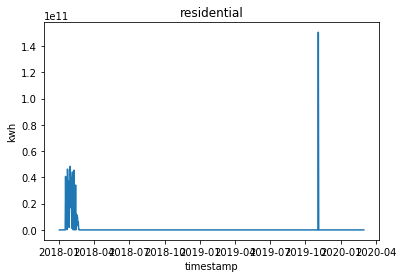

In [13]:
plt.plot(residential)
plt.xlabel('timestamp')
plt.ylabel('kwh')
plt.title('residential')


Text(0.5, 1.0, 'outlier detection')

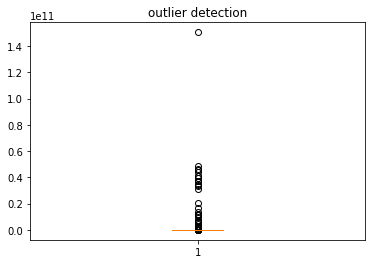

In [14]:
# CHECKING OUTLIERS
plt.boxplot(residential['0'])
plt.title('outlier detection')
# lot of outliers

2769.126796623429

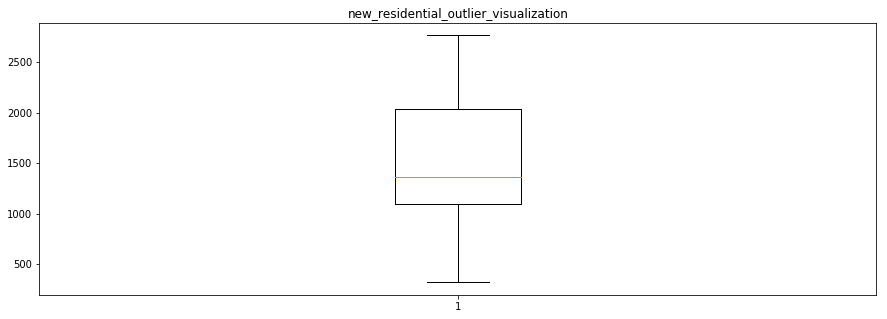

In [22]:
Q3= residential['0'].quantile(0.95)
residential1=residential[residential['0']<Q3]
fig, ax1 = plt.subplots(1, figsize=(15,5))
ax1.boxplot(residential1['0'])
ax1.set_title('new_residential_outlier_visualization')
# NO OUTLIERS NOW
Q3

Text(0.5, 1.0, 'residential')

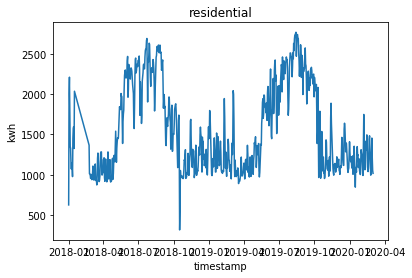

In [24]:
plt.plot(residential1)
plt.xlabel('timestamp')
plt.ylabel('kwh')
plt.title('residential')

In [25]:
def make_features(dataframe,time_level):
    s=dataframe
    start_time=s.index[0]
    end_time=s.index[-1]
    example_ts=s
    example_ts['dayofyear_cos']=np.cos(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['dayofyear_sin']=np.sin(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['month_cos']=np.cos(example_ts.index.month*(2.*np.pi/12))
    example_ts['month_sin']=np.sin(example_ts.index.month*(2.*np.pi/12))
    example_ts['year'] = example_ts.index.year
    example_ts['dayofweek_sin']=np.sin(example_ts.index.weekday*(2.*np.pi/7))
    example_ts['dayofweek_cos']=np.cos(example_ts.index.weekday*(2.*np.pi/7))
    example_ts['weekofyear_cos']=np.cos(example_ts.index.weekofyear*(2.*np.pi/52))
    example_ts['weekofyear_sin']=np.sin(example_ts.index.weekofyear*(2.*np.pi/52))


    for ts in example_ts.index:
        if time_level=='hourly':
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourly[weather_austin_hourly.index == ts] 
        else:
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_daily[weather_austin_daily.index == ts]

    return example_ts

In [26]:
residential_example_ts=make_features(residential1,'daily')
residential_example_ts.head(3)


,0,dayofyear_cos,dayofyear_sin,month_cos,month_sin,year,dayofweek_sin,dayofweek_cos,weekofyear_cos,weekofyear_sin,TMP
Unnamed: 0,,,,,,,,,,,
2018-01-01 00:00:00+00:00,628.346108,0.999852,0.017213,0.866025,0.5,2018,0.000000,1.000000,0.992709,0.120537,-2.1
2018-01-02 00:00:00+00:00,2001.860332,0.999407,0.034422,0.866025,0.5,2018,0.781831,0.623490,0.992709,0.120537,-1.5
2018-01-03 00:00:00+00:00,2209.102122,0.998667,0.051620,0.866025,0.5,2018,0.974928,-0.222521,0.992709,0.120537,3.1


Text(0.5, 1.0, 'weekofyear')

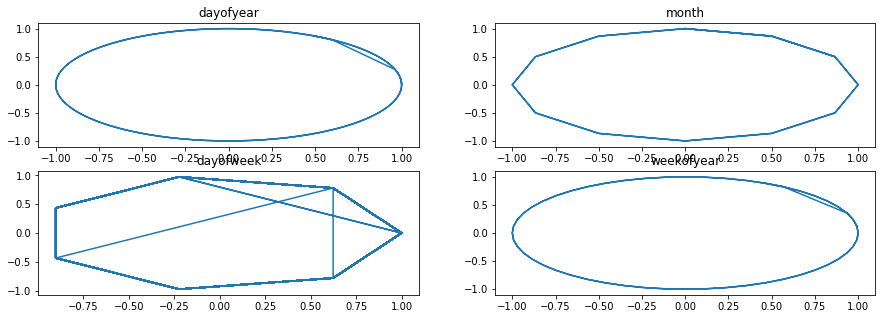

In [27]:
# Cyclic Features
fig, axs = plt.subplots(2,2, figsize=(15,5))
axs[0,0].plot(residential_example_ts['dayofyear_cos'],residential_example_ts['dayofyear_sin'])
axs[0,0].set_title('dayofyear')
axs[0,1].plot(residential_example_ts['month_cos'],residential_example_ts['month_sin'])
axs[0,1].set_title('month')
axs[1,0].plot(residential_example_ts['dayofweek_cos'],residential_example_ts['dayofweek_sin'])
axs[1,0].set_title('dayofweek')
axs[1,1].plot(residential_example_ts['weekofyear_cos'],residential_example_ts['weekofyear_sin'])
axs[1,1].set_title('weekofyear')

0.6933910554955417

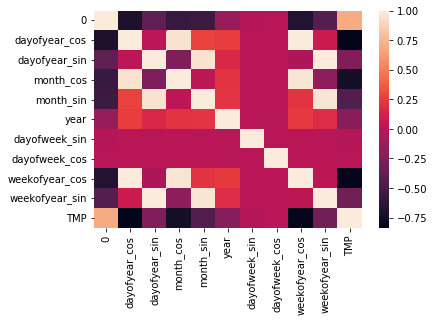

In [28]:
sns.heatmap(residential_example_ts.corr());
residential_example_ts['TMP'].corr(residential_example_ts['0'])

Text(0.5, 1.0, 'residential')

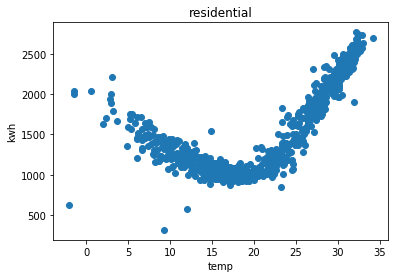

In [29]:
plt.scatter(residential_example_ts['TMP'],residential_example_ts['0'])
plt.xlabel('temp')
plt.ylabel('kwh')
plt.title('residential')

In [30]:
pipeline_baseline=make_pipeline(RandomForestRegressor())
pipeline_baseline_regression=make_pipeline(LinearRegression())

In [31]:
X_train=residential_example_ts[residential_example_ts.columns[1:]]['2018-01-01':'2019-10-21']
y_train=residential_example_ts['0']['2018-01-01':'2019-10-21']
X_test=residential_example_ts[residential_example_ts.columns[1:]]['2019-10-21':]
y_test=residential_example_ts['0']['2019-10-21':]


In [32]:
#cross validation
X=residential_example_ts[residential_example_ts.columns[1:]]
y=residential_example_ts['0']
score=cross_val_score(pipeline_baseline,X,y,cv=10,scoring='r2').mean()
print(f'Score of baseline  model  is ',round(score,4))


Score of baseline  model  is  0.752


In [33]:
score=cross_val_score(pipeline_baseline_regression,X,y,cv=10,scoring='r2').mean()
score

-1.2910496053337062

In [45]:
pred_rf=pipeline_baseline.fit(X_train,y_train).predict(X_test)
pred_lr=pipeline_baseline_regression.fit(X_train,y_train).predict(X_test)


MSE: 107.3471547011559
MAE: 80.05152779594118


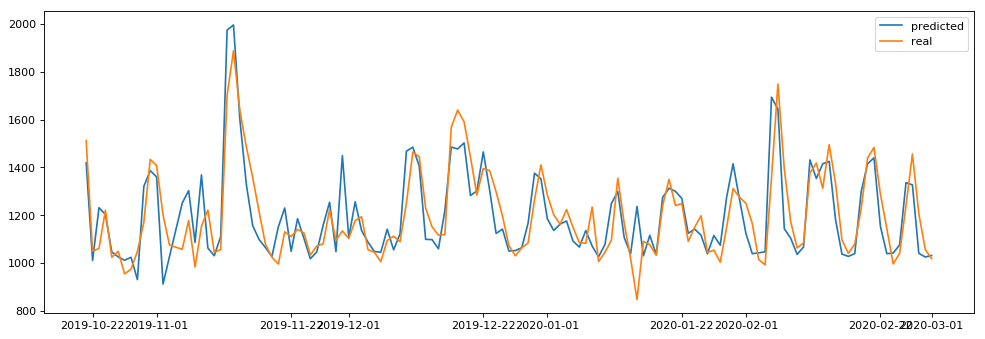

In [43]:
figure(figsize=(15,5), dpi=80)
plt.plot(y_test.index,pred_rf,label='predicted')
plt.plot(y_test.index,y_test,label='real')
plt.legend()
print(f'MSE:' ,mean_squared_error(y_test,pred_rf,squared=False))
print(f'MAE:' ,mean_absolute_error(y_test,pred_rf))
plt.show()

MSE: 314.29066859948574
MAE: 257.23277436976514


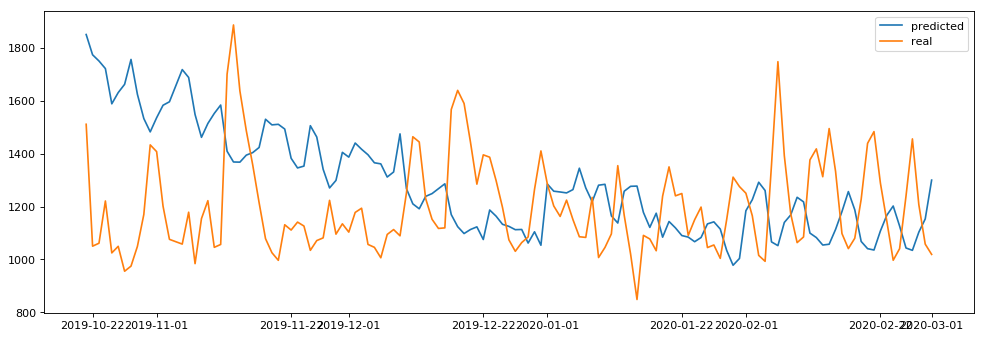

In [50]:
figure(figsize=(15,5), dpi=80)
plt.plot(y_test.index,pred_lr,label='predicted')
plt.plot(y_test.index,y_test,label='real')
plt.legend()
print(f'MSE:' ,mean_squared_error(y_test,pred_lr,squared=False))
print(f'MAE:' ,mean_absolute_error(y_test,pred_lr))
plt.show()